In [66]:
import numpy as np
from math import sin, cos, pi
import matplotlib.pyplot as plt
from scipy.stats import qmc
import yfinance as yf
%matplotlib widget

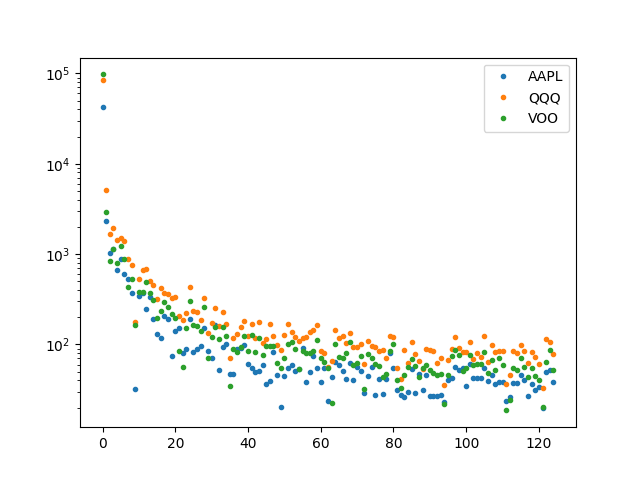

In [73]:
plt.figure()

tickers  = ['AAPL', 'QQQ', 'VOO']
for ticker in tickers:
    yfticker = yf.Ticker(ticker)
    history_data = yfticker.history(period='1y')
    prices = np.array(history_data["Close"])
    prices = prices[~np.isnan(prices)]

    nyquist_freq = len(prices) // 2
    spectrum = np.fft.fft(prices)[:nyquist_freq]

    plt.plot(np.abs(spectrum), '.', label=ticker)

plt.yscale('log')
plt.legend()


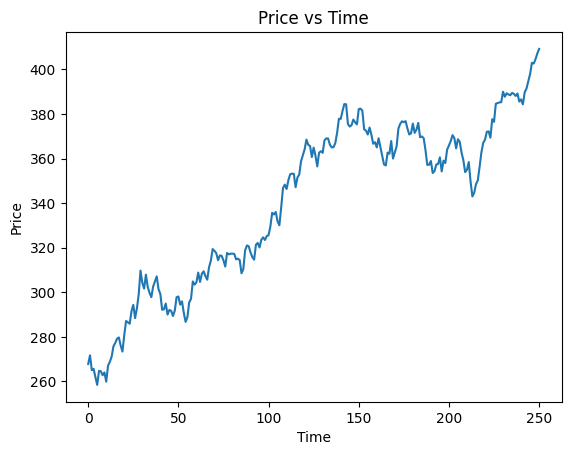

In [46]:
plt.plot(prices)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price vs Time')
plt.show()


267.8312683105469
10.358181190552498


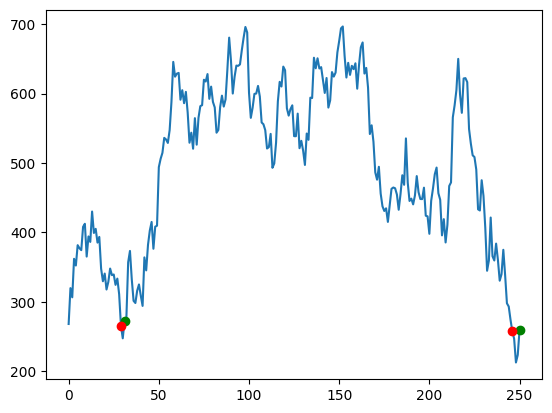

In [47]:
T = len(prices) #number of time steps
n = nyquist_freq #number of fourier terms
# As = 1 / np.arange(1,n+1) #amplitudes of fourier terms
As = np.abs(spectrum) #amplitudes of fourier terms
start_price = prices[0]

thresS = 1
thresB = -1
sell_max = 20
buy_max= 20

thetas = np.random.uniform(0, 2*pi, size=n) #phases of fourier terms

offset = -2*pi/T*sum(As*np.sin(thetas)) + start_price

last_trans = start_price
invest = 0 #shares
cash = 10 

sell_log = []
buy_log = []

P = np.zeros(T)
for k in range(T):
    t = 2*pi*k/T
    for i in range(n):
        P[k] += As[i]*sin(i*t + thetas[i])
    P[k] *= 2*pi/T
    P[k] += offset

    if(P[k] > last_trans + thresS and invest > 0):
        sell_amt = min(sell_max, invest*P[k])
        invest -= sell_amt/P[k]
        cash += sell_amt
        sell_log.append(k)
        # print(f"sell {sell_amt/P[k]} shares at {P[k]} for ${sell_amt}, cash={round(cash,2)}, invest={round(invest,2)}")
        last_trans = P[k]
    if(P[k] < last_trans + thresB and cash > 0):
        buy_amt = min(buy_max, cash)
        invest += buy_amt/P[k]
        cash -= buy_amt
        buy_log.append(k)
        # print(f"buy {buy_amt/P[k]} shares at {P[k]} for -${buy_amt}, cash={round(cash,2)}, invest={round(invest,2)}")
        last_trans = P[k]

plt.plot(P)
for k in sell_log:
    plt.plot(k, P[k], 'go')
for k in buy_log:
    plt.plot(k, P[k], 'ro')

print(f"{P[0]}")
print(cash + invest*P[-1])

Average of money-log: 30.651873283531465


Text(0, 0.5, 'Frequency')

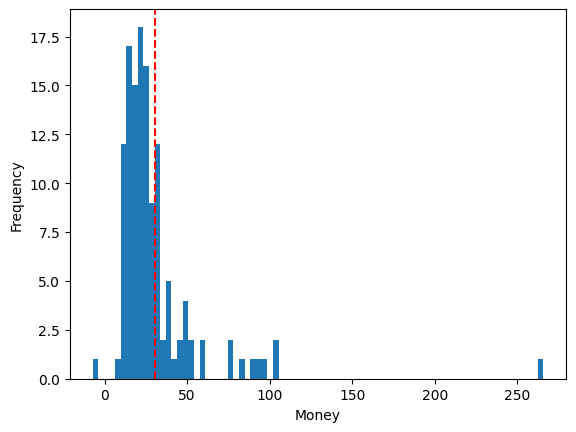

In [55]:
T = len(prices) #number of time steps
n = nyquist_freq #number of fourier terms
# As = 1 / np.arange(1,n+1) #amplitudes of fourier terms
As = np.abs(spectrum) #amplitudes of fourier terms
start_price = prices[0]

thresS = 1
thresB = -1
sell_max = 20
buy_max= 20

trials = 2**7
lhc = qmc.Sobol(d=n)
thetass = lhc.random(trials) * 2*pi

money_log = []
for trial in range(trials):
    # thetas = np.random.uniform(0, 2*pi, size=n) #phases of fourier terms
    thetas = thetass[trial]

    offset = -2*pi/T*sum(As*np.sin(thetas)) + start_price

    last_trans = start_price
    invest = 0 #shares
    cash = 10


    P = np.zeros(T)
    for k in range(T):
        t = 2*pi*k/T
        for i in range(n):
            P[k] += As[i]*sin(i*t + thetas[i])
        P[k] *= 2*pi/T
        P[k] += offset

        if(P[k] > last_trans + thresS and invest > 0):
            sell_amt = min(sell_max, invest*P[k])
            invest -= sell_amt/P[k]
            cash += sell_amt
            last_trans = P[k]
        if(P[k] < last_trans + thresB and cash > 0):
            buy_amt = min(buy_max, cash)
            invest += buy_amt/P[k]
            cash -= buy_amt
            last_trans = P[k]

    money_log.append(cash + invest*P[-1])

average_money_log = sum(money_log) / len(money_log)
print(f"Average of money-log: {average_money_log}")

plt.hist(money_log, bins=80)
plt.axvline(x=average_money_log, color='r', linestyle='--')

plt.xlabel('Money')
plt.ylabel('Frequency')

buy 5.66 shares at 265.07 for -$1500.0, cash=8500.0, invest=5.66
sel 5.65 shares at 265.67 for +$1500.0, cash=10000.0, invest=0.01
buy 5.73 shares at 261.91 for -$1500.0, cash=8500.0, invest=5.74
buy 5.8 shares at 258.45 for -$1500.0, cash=7000.0, invest=11.54
sel 5.67 shares at 264.75 for +$1500.0, cash=8500.0, invest=5.88
buy 5.71 shares at 262.8 for -$1500.0, cash=7000.0, invest=11.59
sel 5.68 shares at 264.06 for +$1500.0, cash=8500.0, invest=5.91
buy 5.77 shares at 259.92 for -$1500.0, cash=7000.0, invest=11.68
sel 5.62 shares at 267.1 for +$1500.0, cash=8500.0, invest=6.06
sel 5.58 shares at 268.82 for +$1500.0, cash=10000.0, invest=0.48
sel 0.48 shares at 271.1 for +$130.19, cash=10130.19, invest=0.0
buy 5.43 shares at 276.12 for -$1500.0, cash=8630.19, invest=5.43
buy 5.49 shares at 273.41 for -$1500.0, cash=7130.19, invest=10.92
sel 5.34 shares at 280.89 for +$1500.0, cash=8630.19, invest=5.58
sel 5.22 shares at 287.13 for +$1500.0, cash=10130.19, invest=0.35
buy 5.23 shares a

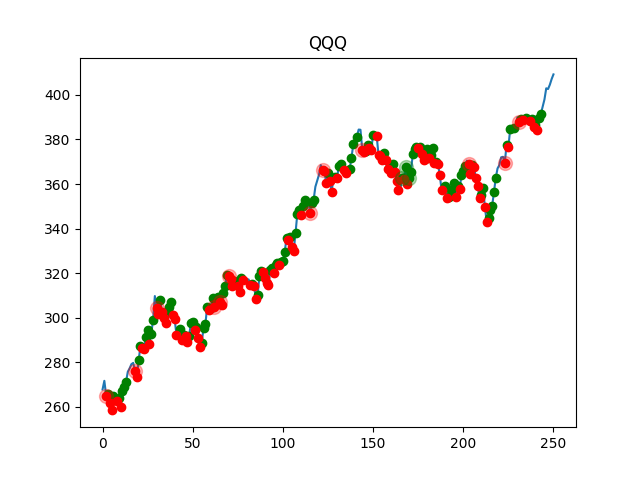

In [153]:
thresS = 0.1 / 100 #percentage 0-1
thresB = -0.1 / 100
start_cash = 10000
sell_max = 0.15 * start_cash
buy_max= 0.15 * start_cash

last_trans = start_price
invest = 0 #shares
cash = start_cash

sell_log = []
buy_log = []

ticker = 'QQQ'
yfticker = yf.Ticker(ticker)
history_data = yfticker.history(period='1y')
prices = np.array(history_data["Close"])
prices = prices[~np.isnan(prices)]

no_money = []
no_shares = []

for k in range(len(prices)):
    P[k] = prices[k]

    # if((P[k] > last_trans + thresS or (cash <= 0 and P[k] > P[k-1] + thresS)) and invest > 0):
    if(((P[k] - last_trans)/last_trans > thresS) and invest > 0):
        if(cash <= 0 and P[k] > P[k-1] + thresS):
            no_money.append(k)
        sell_amt = min(sell_max, invest*P[k])
        invest -= sell_amt/P[k]
        cash += sell_amt
        sell_log.append(k)
        print(f"sel {round(sell_amt/P[k], 2)} shares at {round(P[k], 2)} for +${round(sell_amt, 2)}, cash={round(cash, 2)}, invest={round(invest, 2)}")
        last_trans = P[k]
    if(((P[k] - last_trans)/last_trans < thresB or (invest <= 0 and (P[k]-P[k-1])/P[k-1] < thresB)) and cash > 0):
        if(invest <= 0 and P[k] < P[k-1] + thresB):
            no_shares.append(k)
        buy_amt = min(buy_max, cash)
        invest += buy_amt/P[k]
        cash -= buy_amt
        buy_log.append(k)
        print(f"buy {round(buy_amt/P[k], 2)} shares at {round(P[k], 2)} for -${round(buy_amt, 2)}, cash={round(cash,2)}, invest={round(invest,2)}")
        last_trans = P[k]

base_return = 100 * (P[-1] - P[0]) / P[0]
print(f"base rate: {base_return}%")

plt.figure()
plt.plot(P)
for k in sell_log:
    plt.plot(k, P[k], 'go', label='sell')
for k in buy_log:
    plt.plot(k, P[k], 'ro', label='buy')
for k in no_shares:
    plt.plot(k, P[k], 'ro', markersize=10, alpha=0.3)
for k in no_money:
    plt.plot(k, P[k], 'go', markersize=10, alpha=0.3)

earned = (cash + invest*P[-1]) - start_cash
earned_rate = 100 * earned/start_cash
# print(f"cashback: {earned}")
print(f"earn rate %: {earned_rate}")
# plt.legend()
plt.title(ticker)
plt.show()